# CaloriePhone: food-to-calorie translation

***

Team 509, Final Deep Learning Project, College of Management Academic Studies

Team members:
- Or Reuven
- Vladislav Poberezhny
- Dana Sultan
- Rafael Navon

Team instructor: Kfir Bar

***

Track your calorie intake with a simple photo! Caloriephone lets you take a single picture o
f your meal and then uses deep learning magic to calculate the amount of calories you are about to eat. The motivation is to make life easier for those who work out or are on a diet.

Behind the scenes, this is a multi-class multi-label deep learning model which uses transfer learning and various machine learning techniques to classify foods depicted in a given image. This data is then used to translate the foods to their calorie amount and sum it all up to return the amount of calories present in a given image.

<p align="center">
  <img width="400" height="400" src="samples/1.png">
</p>

This notebook will chronologically follow the building (and trail and error) process of us trying different approaches and techniques in order to train an optimal model to be used in our application. You will see how we have tried and implemented the following techniques:

- various pretrained transfer learning models
- dynamic dataset retrieval from an image search engine
- fine tuning on selected pretrained model layers
- custom loss function implementation to better suit our model
- data augmentation to make most out of a limited dataset and to squeeze it's full potential
- one-hot encoding of labels for multi-label classification purposes
- dynamic learning rate scheduling
- early stopping callback technique to avoid eventual overfitting
- working with multiple datasets (images, CSVs, JSONs)
- python scripting for working with remote APIs and local filesystem
- manual data loading and processing

# Libraries and constants


In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import keras.utils
import sklearn.preprocessing
import sklearn.model_selection
from matplotlib import pyplot as plt
from PIL import Image as pil_image

import getpass
import logging
import time
import requests
import json
import urllib.request
import shutil
import random

2022-06-11 02:53:45.762893: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
tf.__version__
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2022-06-11 02:53:48.188048: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-11 02:53:48.243854: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-11 02:53:48.244275: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


We will be using `InceptionResNetV2` as out base model for transfer learning (this will be explained later in-depth). For now, we define the `IMG_SIZE` to be 299x299, the resolution this model expects.

In [3]:
# InceptionResNetV2 accepts 299x299 images as input
IMG_SIZE = (299, 299)
IMG_SHAPE = IMG_SIZE + (3,)

# various constants
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2
TEST_SPLIT = 0.1

# this path needs to lead to directory of directories per class
DATA_DIR = '/home/vlad/Downloads/test/data'

# Experiment 1: Dynamic dataset

In order to calculate the amount of calories in a single food type, we need some sort of mapping of food to calorie intake. There is a solution for that - we will be using the `vaishnavivenkatesan/food-and-their-calories` kaggle dataset which is a CSV file of different foods and the appropriate amount of calories in a single serving of each.

We need a dataset to match our CSV of food types so we could then use the same labels to convert the food type to it's calorie amount. We have decided to dynamically create the data set based on the labels found in the CSV file by downloading relevant images for each food type from an outside image API.

## Data Preprocessing


Let's retrieve the CSV dataset from kaggle.

In [4]:
# we will need to download the mapping from kaggle datasets
# let's make sure kaggle cli is installed
!python3 -m pip install kaggle

# get log-in credentials
# get credentials from https://www.kaggle.com -> click on your username on the right -> "Account" in the middle bar -> "Create New API Token" 
os.environ["KAGGLE_USERNAME"] = input("Kaggle username: ")
os.environ["KAGGLE_KEY"] = getpass.getpass("Kaggle key: " )

# download mapping
!kaggle datasets download --unzip vaishnavivenkatesan/food-and-their-calories

  0%|                                               | 0.00/6.59k [00:00<?, ?B/s]
100%|██████████████████████████████████████| 6.59k/6.59k [00:00<00:00, 3.96MB/s]


Let's see some entries present in the CSV.

In [5]:
# read food to calorie mapping CSV
mapping_csv = pd.read_csv("Food and Calories - Sheet1.csv")
mapping_csv.head()

,Food,Serving,Calories
0,Artichoke,1 artichoke (128 g),60 cal
1,Arugula,1 leaf (2 g),1 cal
2,Asparagus,1 spear (12 g),2 cal
3,Aubergine,1 aubergine (458 g),115 cal
4,Beetroot,1 beet (82 g),35 cal


Let's see how many food types there are in this CSV:

In [6]:
# each food type is a row
# thus amount of rows is indicative of the amount of possible classes
print(mapping_csv.shape[0])

562


For some reason, the provided CSV contains duplicates of some foods. Let's filter them out.

In [7]:
mapping_csv.drop_duplicates(subset=['Food'], inplace=True)
print(mapping_csv.shape[0])

541


Some of the classes found in this CSV are extremely specific. They include classes such as:

- Big N' Tasty (commercial name for a McDonald's burger)
- Burger King Angry Whopper (also a commercial name, not an actual food type)
- Alphabet Soup	(a soup that has letter shaped pasta in it)

We aim to classify different food types, as opposed to specific foods, so we have decided to filter out some of the classes. The following code will fetch the JSON list of blacklisted foods that we have compiled manually and filter the foods out.

In [8]:
# read a blacklist of foods
food_class_blacklist = []
with open('food_class_blacklist.json', 'r') as food_class_blacklist_file:
  food_class_blacklist = json.loads(food_class_blacklist_file.read())

# filter CSV
mapping_csv_filtered = mapping_csv.drop(mapping_csv[mapping_csv["Food"].isin(food_class_blacklist)].index)

Let's see the amount of classes we are left with:

In [9]:
# each food type is a row
# thus amount of rows is indicative of the amount of possible classes
CLASSES_AMOUNT = mapping_csv_filtered.shape[0]
print(CLASSES_AMOUNT)

98


Now that we have the filtered CSV we need, we can start downloading our data. The following automation queries Unsplash image search API for images and stores them in appropriate train and test directories.

The initial run of the script will take a while because of bandwidth, latency and rate limiting issues.

- a free Unsplash account is allowed to query search API 50 times an hour - meaning 50 searches, each one with 30 results (images). So:
  - in an hour, we can only download 30 * 50 = 1500 images
  - given that we are dealing with 322 classes with 90 images per class (worst case), (322 * 90) / (30 * 50) = ~19 hours in total
- if the notebook is being executed on a local machine, the bandwidth + latency issues come into play. These can be solved by running the script through Google Colab since a virtual machine is being provisioned for execution which is located in a data center. Chances are, this virtual machine is much closer to Unsplash servers than we are. 

The script skips download of a class if a directory for that class is already present, therefore a second run barely takes time since it does not query the API or download anything.

In [10]:
RATE_LIMIT_TIMEOUT_SECONDS = 3720
IMAGE_FORMAT = "jpg"
PAGES_PER_CLASS = 3 # each page gets you 30 images
TEST_SPLIT = 0.2

def query_unsplash_api(url, params, client_id):

    logging.info(f"qeurying API at {url} with params {params} ...")

    rate_limit_reached = False
    response_received = False

    # query api until a response is received
    while not response_received:

      try:

          # query api
          response = requests.get(url, params=params, timeout=60, headers={
              "Accept-Version": "v1",
              "Authorization": f"Client-ID {client_id}"
          })
          response.raise_for_status()

      except requests.HTTPError as e:

          # 403 - rate limit reached
          if e.response.status_code == 403:
            rate_limit_reached = True
          else:
            raise e

      # if HTTP status code is valid - response received
      else:
          response_received = True

      # handle rate limit reached
      if rate_limit_reached or ( response_received and int(response.headers["X-Ratelimit-Remaining"]) == 0 ):
          logging.info(f"rate limit reached, sleeping for {RATE_LIMIT_TIMEOUT_SECONDS} seconds...")
          time.sleep(RATE_LIMIT_TIMEOUT_SECONDS)

    # log remaining rate limit
    logging.info(f"X-Ratelimit-Remaining: {response.headers['X-Ratelimit-Remaining']}")

    return response

def download_data():

    # parse arguments
    CLIENT_ID = getpass.getpass("unsplash.com client ID: ")

    # set-up logger
    logging.basicConfig(level=logging.INFO, format='[%(asctime)s] %(message)s')

    # for each food
    for _, row in mapping_csv_filtered.iterrows():

        # get food and serving fields
        food = row['Food'].strip()
        food_train_path = f"{DATA_DIR}/train/{food}"
        food_test_path = f"{DATA_DIR}/test/{food}"

        # download images only if directory is not yet present
        if os.path.exists(food_train_path):
            
            logging.info(f"'{food_train_path}' already exists, skipping")

        else:

            # initiate food train directory
            os.makedirs(food_train_path)

            # init downloaded image list
            image_names = []

            # iterate result pages
            for page_index in range(PAGES_PER_CLASS):

              # query api for images
              search_response = json.loads(query_unsplash_api("https://api.unsplash.com/search/photos", params={
                  "query": f"{food}",
                  "page": f"{page_index + 1}",
                  "per_page": "30"
              }, client_id=CLIENT_ID).text)

              # iterate search results
              for image in search_response["results"]:

                  # download image
                  image_url = f'{image["urls"]["raw"]}&crop=entropy&w={IMG_SIZE[0]}&h={IMG_SIZE[1]}&fm={IMAGE_FORMAT}'
                  image_path = f"{food_train_path}/{image['id']}.{IMAGE_FORMAT}"
                  logging.info(f"downloading image for '{food}' at {image_url} ...")
                  urllib.request.urlretrieve(image_url, image_path)
                  image_names.append(os.path.basename(image_path))

            # clear food test directory
            if os.path.exists(food_test_path):
              shutil.rmtree(food_test_path)
            os.makedirs(food_test_path)

            # iterate test split
            for image_name_index in range(int(len(image_names) * TEST_SPLIT)):

              # move image to test set
              image_src_path = f"{food_train_path}/{image_names[image_name_index]}"
              image_dst_path = f"{food_test_path}/{image_names[image_name_index]}"
              logging.info(f"moving '{food}' image at {image_src_path} to {image_dst_path}")
              os.rename(image_src_path, image_dst_path)            

# start download process
download_data()

[2022-06-11 02:53:59,109] '/home/vlad/Downloads/test/data/train/Artichoke' already exists, skipping
[2022-06-11 02:53:59,111] '/home/vlad/Downloads/test/data/train/Arugula' already exists, skipping
[2022-06-11 02:53:59,113] '/home/vlad/Downloads/test/data/train/Asparagus' already exists, skipping
[2022-06-11 02:53:59,115] '/home/vlad/Downloads/test/data/train/Aubergine' already exists, skipping
[2022-06-11 02:53:59,116] '/home/vlad/Downloads/test/data/train/Broccoli' already exists, skipping
[2022-06-11 02:53:59,118] '/home/vlad/Downloads/test/data/train/Cabbage' already exists, skipping
[2022-06-11 02:53:59,119] '/home/vlad/Downloads/test/data/train/Carrot' already exists, skipping
[2022-06-11 02:53:59,120] '/home/vlad/Downloads/test/data/train/Cauliflower' already exists, skipping
[2022-06-11 02:53:59,121] '/home/vlad/Downloads/test/data/train/Celery' already exists, skipping
[2022-06-11 02:53:59,123] '/home/vlad/Downloads/test/data/train/Chives' already exists, skipping
[2022-06-11 

Now that the data is present - we can load our training, validation and testing sets and begin construction of our network!

In [11]:
# read entire dataset and split to train, validation and test sets
training_set = tf.keras.utils.image_dataset_from_directory( f"{DATA_DIR}/train",
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            label_mode='categorical',
                                                            validation_split=VALIDATION_SPLIT,
                                                            seed=42,
                                                            subset='training')

validation_set = tf.keras.utils.image_dataset_from_directory(   f"{DATA_DIR}/train",
                                                                shuffle=True,
                                                                batch_size=BATCH_SIZE,
                                                                image_size=IMG_SIZE,
                                                                label_mode='categorical',
                                                                validation_split=VALIDATION_SPLIT,
                                                                seed=42,
                                                                subset='validation')

test_set = tf.keras.utils.image_dataset_from_directory( f"{DATA_DIR}/test",
                                                        shuffle=True,
                                                        batch_size=BATCH_SIZE,
                                                        image_size=IMG_SIZE,
                                                        label_mode='categorical')

Found 6322 files belonging to 98 classes.
Using 5058 files for training.


2022-06-11 02:53:59.643719: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-11 02:53:59.645528: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-11 02:53:59.645646: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-11 02:53:59.645697: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA

Found 6322 files belonging to 98 classes.
Using 1264 files for validation.
Found 1659 files belonging to 98 classes.


The code below will enable buffer prefetching for all sets. This setting will let images load from disk without encountering I/O blocking by allowing TensorFlow to take care of the streaming process, making the learning process faster.

In [12]:
training_set = training_set.prefetch(buffer_size=tf.data.AUTOTUNE)
validation_set = validation_set.prefetch(buffer_size=tf.data.AUTOTUNE)
test_set = test_set.prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the CNN

We will use transfer learning, a technique which uses a pre-trained model, to achieve good results. The model we are going to use is called `InceptionResNetV2`, which has proven itself to work very well with classification in our previous exercises as well as our local tests against other pretrained models.

The model expects a tensor of (299, 299, 3) dimensions:
- 299 pixels in width
- 299 pixels in height
- 3 color channels (red, green, blue)

The resizing of the source image is taken care of by the `tf.keras.utils.image_dataset_from_directory` utility function which not only reads, but also resizes the images to resoluton provided by the `image_size` parameter.

In addition, the model expects the RGB values to be normalized from regular `[0:255]` range for each channel to `[-1:1]` range. This conversion will be taken care of by the model's approprite `base_model_preprocess_input` layer as specified in the code below.

In [13]:
# use InceptionResNetV2 as base model
base_model_function = tf.keras.applications.InceptionResNetV2
base_model_preprocess_input = tf.keras.applications.inception_resnet_v2.preprocess_input

We will instantiate the model from the model function. We will then also freeze the layers of this model so they will not be retrained during the training process. We have to remember that the model is good enough to classify objects on it's own. The model is our means of getting a highly accurate feature map, therefore it should not be retrained.

In [14]:
# init base model
base_model = base_model_function(   input_shape=IMG_SHAPE,
                                    include_top=False,
                                    weights='imagenet')

# freeze base layers
base_model.trainable = False

Segueing from our previous point about not retraining the model, we will employ a technique used in transfer learning called Fine Tuning.

The base model is __GOOD__ as classifying a variety of objects, specifically from the `ImageNet` dataset. What we want it to do is to be __BETTER__ at classifying specific food types as opposed to other classes unrelated to food. Fine tuning allows us to do just that - we will unfreeze some of the final layers which make up the base model to allow them to adjust to our specific needs. The idea is to combine the feature extraction capabilities of the model with its ability to create an accurate feature map fit to our specific dataset.

From our local testing, fine tuning of the layers has increased accuracy of our models __by at least 15%__! That is very impactful.

Let's see how many layers are in the base model.

In [15]:
print(f"Number of layers in the base model: {len(base_model.layers)}")

Number of layers in the base model: 780


We will allow the final 80 layers out of the 780 layers present to be retrained.

In [16]:
# unfreeze the entire model first
base_model.trainable = True

for layer in base_model.layers[:700]:
    layer.trainable = False

We will now store a copy of our base model settings aside for reuse in future experiments.

In [17]:
# store base model copy aside
BASE_MODEL_BACKUP_PATH = "./base_model_backup"
!rm -rf {BASE_MODEL_BACKUP_PATH}
base_model.save(BASE_MODEL_BACKUP_PATH)

[2022-06-11 02:54:03,952] Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
[2022-06-11 02:54:21,943] Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 244). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ./base_model_backup/assets


[2022-06-11 02:54:26,798] Assets written to: ./base_model_backup/assets


Data augmentation is a good idea in our case for the following reasons:
- food can be pictured from a variety of angles
- we are dealing with a relatively small dataset

We also need to be careful not to perform some specific augmentations. For example, cropping or zooming the image might result in an image which does not include the food itself in the picture. We should also not warp or scale the image so the food stays in the same original shape.

In [18]:
# init base layer with augmentations
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.RandomRotation(0.4),
])

Here's a preview of how this augmentation affects our images: 

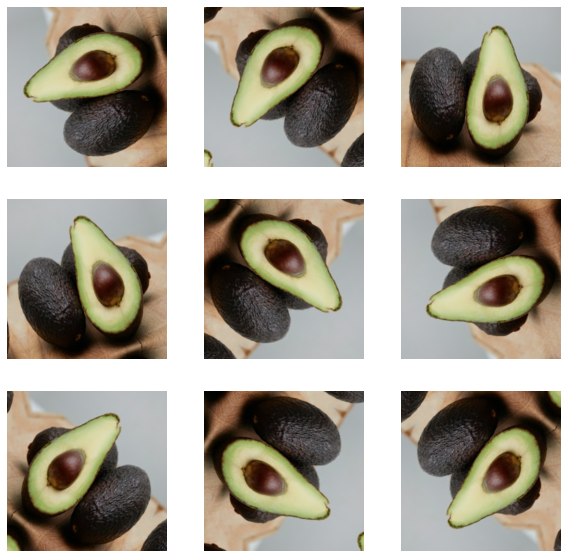

In [19]:
# take single batch
for image, _ in training_set.take(1):

  # prepare plot
  plt.figure(figsize=(10, 10))

  # take first image from batch
  first_image = image[0]

  # display 9 different augmentations of image
  for i in range(9):
    
    axis = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0), training=True)
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

After passing an image through our base model, we will need to generate predictions from returned block of features. This `GlobalAveragePooling2D` layer will convert these features to a single vector.

In [20]:
# convert to vectors for feature extraction 
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

Finally, the prediction layer is needed for our model's output. Each unit in this `Dense` layer accounts for a class. The activation function is `tf.keras.activations.softmax`. This will result in each neuron having a float value representing the probability of a food belonging to the neuron's corresponding class __relative__ to other neurons. This means, the sum of ll the float value of each neuron is 1. This is important for assigning a single class to a single image.

In [21]:
# dense layer of unit per class
prediction_layer = tf.keras.layers.Dense(   units=CLASSES_AMOUNT,
                                            activation=tf.keras.activations.softmax)

Let's combine our model using the following layers:
- input layer with the shape representing our image resolution
- augmentation layer for image augmentation
- preprocess layer so images can be fed to the base model
- `InceptionResNetV2` layers
- `GlobalAveragePooling2D` to convert the feature map
- `Dropout` layer for good measure
- prediction layer so results can be read from the base model

In [22]:
# build model 
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = base_model_preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

# show summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 299, 299, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 299, 299, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 299, 299, 3)      0         
 a)                                                              
                                                                 
 inception_resnet_v2 (Functi  (None, 8, 8, 1536)       54336736  
 onal)                                                           
                                                             

## Training the model

The model will now be trained to classify foods based on our classes. We have decided to use `Adam` and `MeanSquaredError` as our optimizer and loss functions as these are appropriate for categorizing problems.

The learning rate is set to a base `0.0001` value. We do not want to overset the learning rate when using transfer learning. 10 epochs should be enough for a first experiment.

In [23]:
model.compile(  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss=tf.keras.losses.MeanSquaredError(),
                metrics=['accuracy'])

history = model.fit(training_set,
                    epochs=10,
                    validation_data=validation_set)

Epoch 1/10


2022-06-11 02:54:33.898427: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201
2022-06-11 02:54:35.142422: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-06-11 02:54:35.143220: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2022-06-11 02:54:35.143226: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2022-06-11 02:54:35.143265: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be 

159/159 [==============================] - 63s 338ms/step - loss: 0.0099 - accuracy: 0.0633 - val_loss: 0.0097 - val_accuracy: 0.1574
Epoch 2/10
159/159 [==============================] - 49s 310ms/step - loss: 0.0092 - accuracy: 0.1959 - val_loss: 0.0090 - val_accuracy: 0.2342
Epoch 3/10
159/159 [==============================] - 48s 299ms/step - loss: 0.0085 - accuracy: 0.2906 - val_loss: 0.0089 - val_accuracy: 0.2824
Epoch 4/10
159/159 [==============================] - 48s 303ms/step - loss: 0.0079 - accuracy: 0.3450 - val_loss: 0.0085 - val_accuracy: 0.3117
Epoch 5/10
159/159 [==============================] - 48s 301ms/step - loss: 0.0073 - accuracy: 0.4013 - val_loss: 0.0084 - val_accuracy: 0.3252
Epoch 6/10
159/159 [==============================] - 48s 299ms/step - loss: 0.0069 - accuracy: 0.4346 - val_loss: 0.0082 - val_accuracy: 0.3457
Epoch 7/10
159/159 [==============================] - 48s 299ms/step - loss: 0.0065 - accuracy: 0.4767 - val_loss: 0.0082 - val_accuracy: 0.3

## Visualization of Loss and Accuracy

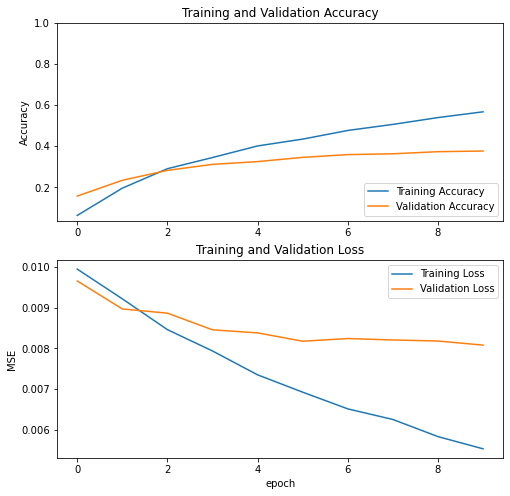

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('MSE')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

We see that the training has stopp just before validational accuracy and loss have began converging back to their original positions, meaning the training process stopped just as it began to overfit. Good timing!

## Model evaluation

In [25]:
model.evaluate(test_set)

52/52 [==============================] - 12s 237ms/step - loss: 0.0087 - accuracy: 0.3406


[0.008667274378240108, 0.34056660532951355]

As we can see, the model performs OK, but not good enough in terms of accuracy is suspiciously good in terms of loss. The loss value is extremely low all the way and drops very slightly. A pretrained model should be performing better than that alone.

# Experiment 2: A more mature dataset

We have arrived at the conclusion that our dynamic data set was incompatible. Some images were too generic and some were not fitting - showing us unrelated search results. For instance, upon searching the word `kiwi` in the search API, in some cases it would return us pictures of the bird, instead of the images of the fruit.

<p align="center">
  <img width="400" height="400" src="https://upload.wikimedia.org/wikipedia/commons/8/82/TeTuatahianui.jpg">
  <img width="400" height="400" src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/de/Kiwifruit_cross_section.jpg/1280px-Kiwifruit_cross_section.jpg">
</p>

We understood that we needed to work with a dataset that is more fit to the food classification task if we want to achieve greater accuracy. We could just continue using our dataset and get the promised ~33% of accuracy, but we have decided that it is more important to achieve better results.

## Data preprocessing

We will now be downloading and using the `Food101` dataset which is a very known dataset of 101 classes of foods with 1000 images for each class.

In [26]:
!kaggle datasets download dansbecker/food-101
!unzip -n food-101.zip

food-101.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  food-101.zip


Let's readjust our data related values.

In [27]:
DATA_DIR = 'food-101/food-101/images/'
CLASSES_AMOUNT = 101

In [28]:
# read entire dataset and split to train, validation and test sets
training_set = tf.keras.utils.image_dataset_from_directory( f"{DATA_DIR}",
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            label_mode='categorical',
                                                            validation_split=VALIDATION_SPLIT,
                                                            seed=42,
                                                            subset='training')

validation_set = tf.keras.utils.image_dataset_from_directory(   f"{DATA_DIR}",
                                                                shuffle=True,
                                                                batch_size=BATCH_SIZE,
                                                                image_size=IMG_SIZE,
                                                                label_mode='categorical',
                                                                validation_split=VALIDATION_SPLIT,
                                                                seed=42,
                                                                subset='validation')

Found 101000 files belonging to 101 classes.
Using 80800 files for training.
Found 101000 files belonging to 101 classes.
Using 20200 files for validation.


Just as before, allow TensorFlow to efficiently stream the data from disk.

In [29]:
training_set = training_set.prefetch(buffer_size=tf.data.AUTOTUNE)
validation_set = validation_set.prefetch(buffer_size=tf.data.AUTOTUNE)

Some examples of how augmentation affects the new dataset.

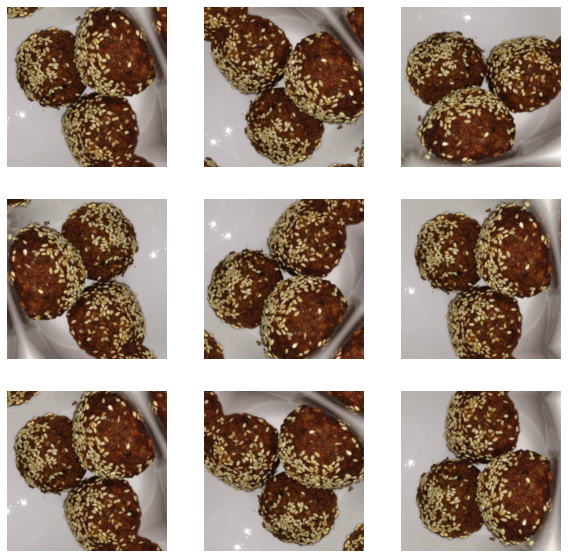

In [30]:
# take single batch
for image, _ in training_set.take(1):

  # prepare plot
  plt.figure(figsize=(10, 10))

  # take first image from batch
  first_image = image[0]

  # display 9 different augmentations of image
  for i in range(9):
    
    axis = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0), training=True)
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## Building the CNN

Prediction layer is the exact same, but the amount of classes has changed.

In [31]:
prediction_layer = tf.keras.layers.Dense(   units=CLASSES_AMOUNT,
                                            activation=tf.keras.activations.softmax)

The last 80 layers of the base model have been retrained in a previous attempt. We will reset the base model variable by cloning the previously saved copy of the untrained base model with initial weights.

In [32]:
base_model = keras.models.load_model(BASE_MODEL_BACKUP_PATH)

[2022-06-11 03:03:35,472] No training configuration found in save file, so the model was *not* compiled. Compile it manually.


Reassembling the model in the same manner as before.

In [33]:
# reassemble model 
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = base_model_preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

# show summary
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 299, 299, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 299, 299, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 299, 299, 3)      0         
 bda)                                                            
                                                                 
 inception_resnet_v2 (Functi  (None, 8, 8, 1536)       54336736  
 onal)                                                           
                                                           

This time around we will let the model train for more epochs, but in order to make sure it learns new things each epoch without fear of overfitting, we will define an early stopping callback which will inspect the accuracy change across 3 latest epochs and will stop the training process if no change has been detected.

In [34]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping( monitor="val_accuracy",
                                                            patience=3,
                                                            min_delta=0.001)

We will now recompile the model with the same configuration as before, adding the additional early stopping callback to the fitting process.

In [35]:
model.compile(  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss=tf.keras.losses.MeanSquaredError(),
                metrics=['accuracy'])

history = model.fit(training_set,
                    epochs=12,
                    validation_data=validation_set,
                    callbacks=[early_stopping_callback])

Epoch 1/12
2525/2525 [==============================] - 762s 300ms/step - loss: 0.0067 - accuracy: 0.4490 - val_loss: 0.0050 - val_accuracy: 0.6211
Epoch 2/12
2525/2525 [==============================] - 722s 286ms/step - loss: 0.0049 - accuracy: 0.6290 - val_loss: 0.0043 - val_accuracy: 0.6806
Epoch 3/12
2525/2525 [==============================] - 727s 288ms/step - loss: 0.0043 - accuracy: 0.6789 - val_loss: 0.0039 - val_accuracy: 0.7111
Epoch 4/12
2525/2525 [==============================] - 705s 279ms/step - loss: 0.0039 - accuracy: 0.7098 - val_loss: 0.0038 - val_accuracy: 0.7234
Epoch 5/12
2525/2525 [==============================] - 706s 280ms/step - loss: 0.0036 - accuracy: 0.7334 - val_loss: 0.0036 - val_accuracy: 0.7345
Epoch 6/12
2525/2525 [==============================] - 705s 279ms/step - loss: 0.0034 - accuracy: 0.7514 - val_loss: 0.0035 - val_accuracy: 0.7399
Epoch 7/12
2525/2525 [==============================] - 705s 279ms/step - loss: 0.0032 - accuracy: 0.7675 - val_

## Visualization of Loss and Accuracy

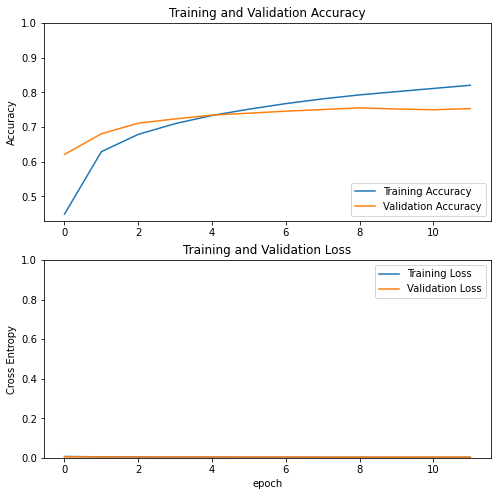

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Our new model has outperformed the previous one by simply using a more precise, unbiast and richer dataset. We can now employ this architecture to create our multi-class, multi-label classifier of foods.

# Experiment 3: Multi-label classifier

Suppose this model can classify a single food type from a single image, but that is not enough. Our goal is to be able to classify all kinds of foods that are present in the picture - a plate of food, for instance.

An approach to building a multi-label classifier will be a little different. We know for a fact that each 1000 images in a directory for a class belongs to that single class, but the classifier we are about to build must get a list of labels for each image (as opposed to a single label per image) so it could understand that data and return a list of labels for each image upon prediction. We will be preparing the dataset manually this time, explaining things along the way.

## Data preprocessing

We are going to create a list of train data and a matching list of labels for that data. Same thing with the validation data. The important part is to keep these lists in the proper order, since the index for the image in the dataset must correspond with the set of labels for that same image in the label list. This must be true for training, validation and test sets.

In [37]:
# in this script, we are going to create X_train, X_val, y_train, y_val of data
# where 'X' is paths to food images and 'y' is a list of just one item - its label (class)

data_tuples = []

# iterate food types
for food_type in os.listdir(DATA_DIR):
    
    food_type_path = os.path.join(DATA_DIR, food_type)

    if (os.path.isdir(food_type_path)):

        # iterate food images
        for food_image_name in os.listdir(food_type_path):
            data_tuples.append((os.path.join(food_type_path, food_image_name), [food_type]))

# shuffle list for randomness
random.shuffle(data_tuples)

# split to train and validation
split_index = int(len(data_tuples) * (1 - VALIDATION_SPLIT))
train_tuples = data_tuples[:split_index]
val_tuples = data_tuples[split_index:]

print(f"Using {len(train_tuples)} files for training.")
print(f"Using {len(val_tuples)} files for validation.")

# unpack train and validation
X_train, y_train = zip(*train_tuples)
X_val, y_val = zip(*train_tuples)

# cast to lists instead of tuples
X_train = list(X_train)
y_train = list(y_train)
X_val = list(X_val)
y_val = list(y_val)

Using 80800 files for training.
Using 20200 files for validation.


We will also take a small portion of train data for testing.

In [38]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_train,
                                                                            y_train,
                                                                            test_size=TEST_SPLIT)

Here is how our input to the multilabel classifier looks:

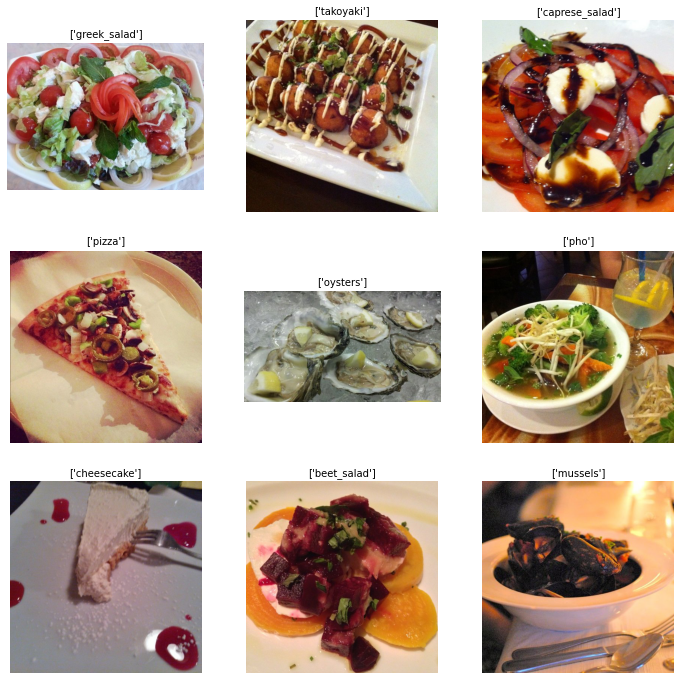

In [39]:
# prepare plot dimensions
n_images = 9
n_columns = 3
n_rows = n_images // n_columns

# display plot of images and their respective labels
plt.figure(figsize=(12,4*n_rows))
for i in range(n_rows * n_columns):

    axis = plt.subplot(n_rows, n_columns, i+1)
    plt.imshow(pil_image.open(X_train[i]))
    plt.title(y_train[i], size=10)
    plt.axis('off')

We will now need to encode our labels so the NN can understand it. We will need to one-hot encode them - instead of using a plain text to represent a label, we will use set 'bits' in a list.

In [40]:
# MultiLabelBinarizer class lets use one-hot encode labels easily
mlb = sklearn.preprocessing.MultiLabelBinarizer()
mlb.fit(y_train)

# encode labels
y_train_encoded = mlb.transform(y_train)
y_val_encoded = mlb.transform(y_val)
y_test_encoded = mlb.transform(y_test)

# print encoded representation
for (index, label) in enumerate(mlb.classes_):
    print(f"{index} {label}")

0 apple_pie
1 baby_back_ribs
2 baklava
3 beef_carpaccio
4 beef_tartare
5 beet_salad
6 beignets
7 bibimbap
8 bread_pudding
9 breakfast_burrito
10 bruschetta
11 caesar_salad
12 cannoli
13 caprese_salad
14 carrot_cake
15 ceviche
16 cheese_plate
17 cheesecake
18 chicken_curry
19 chicken_quesadilla
20 chicken_wings
21 chocolate_cake
22 chocolate_mousse
23 churros
24 clam_chowder
25 club_sandwich
26 crab_cakes
27 creme_brulee
28 croque_madame
29 cup_cakes
30 deviled_eggs
31 donuts
32 dumplings
33 edamame
34 eggs_benedict
35 escargots
36 falafel
37 filet_mignon
38 fish_and_chips
39 foie_gras
40 french_fries
41 french_onion_soup
42 french_toast
43 fried_calamari
44 fried_rice
45 frozen_yogurt
46 garlic_bread
47 gnocchi
48 greek_salad
49 grilled_cheese_sandwich
50 grilled_salmon
51 guacamole
52 gyoza
53 hamburger
54 hot_and_sour_soup
55 hot_dog
56 huevos_rancheros
57 hummus
58 ice_cream
59 lasagna
60 lobster_bisque
61 lobster_roll_sandwich
62 macaroni_and_cheese
63 macarons
64 miso_soup
65 muss

The batch and buffer size are now set to these values because we are going to implement a custom loss function which uses F1 scoring to deduce labels. More on that will be explained at the loss function setup stage below.

In [41]:
BATCH_SIZE = 256
BUFFER_SIZE = 512

Since we created our dataset lists manually, we will parse them manually as well, using helper functions below.

- `parse_data` is a function which accepts a path to an image and it's set of labels. It then takes care of loading, decoding and resizing the image, something which was previously handled by the `tf.keras.utils.image_dataset_from_directory` utility function. It then returns the processed image and labels.

- `parse_dataset` is a function which accepts a list of filepaths as well as set of labels corresponding to the filepaths. It then takes care of parsing each image and labels using the `parse_data` function, shuffles the data using the aforementioned `BUFFER_SIZE` as buffer size. The data is then batched with the batch size being the aforementioned `BATCH_SIZE` and the prefetch is set to `AUTOTUNE` same as in our previous attempts.

In [42]:
def parse_data(filename, label):

    # read image bytes
    image_bytes = tf.io.read_file(filename)

    # read as jpeg
    image_decoded = tf.image.decode_jpeg(image_bytes, channels=3)

    # resize image
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE[0], IMG_SIZE[1]])

    return image_resized, label

def parse_dataset(filenames, labels, is_training=True):
    
    # init dataset
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))

    # parse data using parse function
    dataset = dataset.map(parse_data, num_parallel_calls=tf.data.AUTOTUNE)
    
    if is_training == True:

        # shuffle data
        dataset = dataset.shuffle(buffer_size=BUFFER_SIZE)
        
    # batch data
    dataset = dataset.batch(BATCH_SIZE)

    # prefetch from disk
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return dataset

We will now parse our sets to arrive to our final sets of tensors.

In [43]:
training_set = parse_dataset(X_train, y_train_encoded)
validation_set = parse_dataset(X_val, y_val_encoded)
test_set = parse_dataset(X_test, y_test_encoded)

To make sure everything is in order, we can inspect the `element_spec` of the dataset too see what our tensors consist of.

In [44]:
print(training_set.element_spec)

(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.int64, name=None))


We can see that each element in a batch is a tuple of 2 tensors:

- tensor of shape `(None, 299, 299, 3)` where `None` should represent the shape but is irrelevant to the element specification itself (therefore the value is not set), `299x299` pixels and 3 color channels

- tensor of shape `(None, 101)` where `None` is the same as above and `101` is the amount of total classes that the data is classified with

#### F1 score loss function

We have decided to improve upon our loss function which affects negatively on the training process by implementing a custom loss function which is based on F1 score measurement.

F1 score is a measure of accuracy derived from a mean value of:
- __precision__: amount of true positive results divided by the amount of all positive results
- __recall__: amount of true positive results divided by the amount of all samples which should have been positive

F1 score is calculated using the following formula:

<p align="center">
  <img width="400" height="400" src="https://datascience103579984.files.wordpress.com/2019/04/capture3-24.png">
</p>

F1 score will be computed separately over a batch of 256 results. That is why we changed the `BATCH_SIZE` from being 32 to 256 - so we could get a more accurate mean value. It will be computed 101 times, once per label to compute the mean across all labels evenly.

F1 score only works with binary predictions - "whether the specific class is present on the image or not". Therefore, during F1 score evaluation, we will define a threshold and a class will be considered present if it is above the threshold.

The loss function, though, needs to be differentiable and not binary. So what we will do is compute a sum of probabilities instead.

For example, if the image has waffles in it, but the model predicted that there is 0.75 chance of waffles being in the image, the true positive value will be 0.75 and the false negative value will be 0.25. This way we will achieve differentiality for our loss function.

In [45]:
@tf.function
def f1_score_loss(label_tensor, matrix_tensor):

    # cast to float32 as we are dealing with float values
    label_tensor = tf.cast(label_tensor, tf.float32)
    matrix_tensor = tf.cast(matrix_tensor, tf.float32)

    # calculate confusion matrix values
    # - TP: true positive
    # - FP: false positive
    # - FN: true negative
    TP = tf.reduce_sum(matrix_tensor * label_tensor, axis=0)
    FP = tf.reduce_sum(matrix_tensor * (1 - label_tensor), axis=0)
    FN = tf.reduce_sum((1 - matrix_tensor) * label_tensor, axis=0)

    # use F1 score formula to calculate F1 score
    f1 = (2*TP) / (2*TP + FN + FP + 1e-16)

    # deduce cost from calculated F1 score
    cost = 1 - f1

    # deduce average across all labels
    avg_cost = tf.reduce_mean(cost)
    
    return avg_cost

@tf.function
def f1_score_metric(label_tensor, matrix_tensor, thresh=0.1):

    # get prediction if greater than threshold
    label_tensor_filtered = tf.greater(matrix_tensor, thresh)

    # cast to float32 as we are dealing with float values
    label_tensor_prediction = tf.cast(label_tensor_filtered, tf.float32)
    matrix_tensor = tf.cast(matrix_tensor, tf.float32)

    # calculate confusion matrix values
    # - TP: true positive
    # - FP: false positive
    # - FN: true negative
    TP = tf.cast(tf.math.count_nonzero(label_tensor_prediction * label_tensor, axis=0), tf.float32)
    FP = tf.cast(tf.math.count_nonzero(label_tensor_prediction * (1 - label_tensor), axis=0), tf.float32)
    FN = tf.cast(tf.math.count_nonzero((1 - label_tensor_prediction) * label_tensor, axis=0), tf.float32)

    # use F1 score formula to calculate F1 score for current batch
    f1 = (2*TP) / (2*TP + FN + FP + 1e-16)

    # deduce average across all labels for current batch
    f1 = tf.reduce_mean(f1)

    return f1

## Building multi-label classifier CNN

This time around our prediction layer will use the `tf.keras.activations.sigmoid` instead of `tf.keras.activations.softmax`. We explained before that sum of all values in each neuron of the prediction layer will be 1, which is good for single label prediction. This time we want each probability to be calculated independently so multiple valid labels can be returned.

In [46]:
prediction_layer = tf.keras.layers.Dense(   CLASSES_AMOUNT,
                                            activation=tf.keras.activations.sigmoid,
                                            name='prediction')

Let's reassemble our final model architecture.

In [47]:
base_model = keras.models.load_model(BASE_MODEL_BACKUP_PATH)

# reassemble model 
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = base_model_preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

# show summary
model.summary()

[2022-06-11 05:26:28,522] No training configuration found in save file, so the model was *not* compiled. Compile it manually.


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 299, 299, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 299, 299, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 299, 299, 3)      0         
 bda)                                                            
                                                                 
 inception_resnet_v2 (Functi  (None, 8, 8, 1536)       54336736  
 onal)                                                           
                                                           

## Training the model

When compiling the model, we will specify our custom loss function and the previously defined early stopping callback. Additionally, we will specify a custom learning rate scheduler to dynamically control the learning rate of our training process so it would not get stuck. We have a lot of data, therefore we will enlarge the amount of epochs to 25. The scheduler will work as follows:

- start slowly with the usual 0.0001 learning rate value for the first 10 epochs
- double it for the rest of the epochs

In [48]:
# define scheduler function
def lr_scheduler_function(epoch):
    if epoch < 10:
        return 0.0001
    else:
        return 0.0002

# init new scheduler using the function
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_scheduler_function)

We will also need to redefine the early stopping callback since the `monitor` argument value has changed as we are using a new custom F1 score metric.

In [49]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping( monitor="val_f1_score_metric",
                                                            patience=3,
                                                            min_delta=0.001)

In [50]:
model.compile(  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss=f1_score_loss,
                metrics=[f1_score_metric])

history = model.fit(training_set,
                    epochs=15,
                    validation_data=validation_set,
                    callbacks=[early_stopping_callback, lr_scheduler])

Epoch 1/15
253/253 [==============================] - 855s 3s/step - loss: 0.7817 - f1_score_metric: 0.2173 - val_loss: 0.6460 - val_f1_score_metric: 0.3602 - lr: 1.0000e-04
Epoch 2/15
253/253 [==============================] - 835s 3s/step - loss: 0.6286 - f1_score_metric: 0.3710 - val_loss: 0.5570 - val_f1_score_metric: 0.4368 - lr: 1.0000e-04
Epoch 3/15
253/253 [==============================] - 834s 3s/step - loss: 0.5723 - f1_score_metric: 0.4273 - val_loss: 0.5284 - val_f1_score_metric: 0.4713 - lr: 1.0000e-04
Epoch 4/15
253/253 [==============================] - 834s 3s/step - loss: 0.5421 - f1_score_metric: 0.4582 - val_loss: 0.4931 - val_f1_score_metric: 0.5093 - lr: 1.0000e-04


## Visualization of Loss and Accuracy

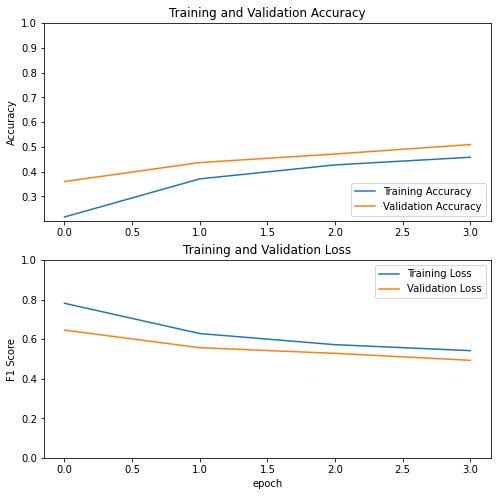

In [51]:
acc = history.history['f1_score_metric']
val_acc = history.history['val_f1_score_metric']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('F1 Score')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

As we can see, the custom loss function has affected the training process positively. The loss is variable and the accuracy is solid!

## Model evaluation

Let's see how the model fairs against the test set.

In [52]:
model.evaluate(test_set)

64/64 [==============================] - 87s 1s/step - loss: 0.5037 - f1_score_metric: 0.4955


[0.5037308931350708, 0.49553734064102173]

We have successfully implemented our own multi-class multi-label food classifier! Let's save it.

In [53]:
model.save("./caloriephone_model")

[2022-06-11 06:24:18,413] Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 244). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ./caloriephone_model/assets


[2022-06-11 06:24:23,670] Assets written to: ./caloriephone_model/assets


## Some predictions

Here we will define a helper prediction function which will process the image and display predictions. We will use the function to quickly display some test images and their predicted labels.

In [54]:
PREDICTION_CUTOFF = 0.25

def predict(image_path, image_labels):

    # read image as model input
    image = keras.utils.load_img(image_path, target_size=IMG_SHAPE)
    image = keras.utils.img_to_array(image)
    image = np.expand_dims(image, axis=0)

    # predict image labels
    prediction = (model.predict(image) > PREDICTION_CUTOFF).astype('int')
    prediction = pd.Series(prediction[0])
    prediction.index = mlb.classes_
    prediction = prediction[prediction==1].index.values

    # display image and prediction
    plt.figure(figsize=(8,4))
    plt.axis('off')
    plt.imshow(pil_image.open(image_path))
    plt.title(f"\nActual labels:\n{image_labels}\n\nPredicted labels:\n{list(prediction)}\n")
    plt.show()

    return prediction

1/1 [==============================] - 2s 2s/step


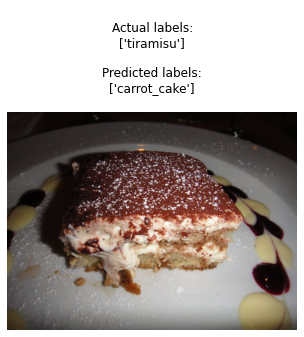

1/1 [==============================] - 0s 23ms/step


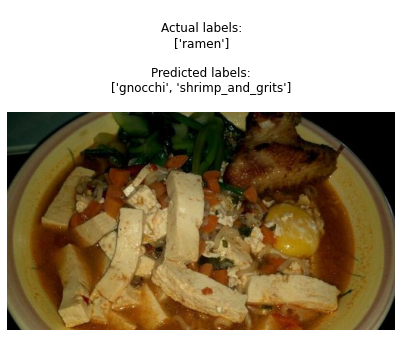

1/1 [==============================] - 0s 23ms/step


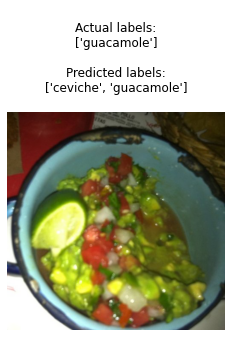

In [55]:
# store and display label predictions
predictions = []

for (test_image_path, test_image_labels) in [
    ("food-101/food-101/images/tiramisu/958418.jpg", ["tiramisu"]),
    ("food-101/food-101/images/ramen/726528.jpg", ["ramen"]),
    ("food-101/food-101/images/guacamole/778243.jpg", ["guacamole"])
]:
    predictions.append((test_image_path, predict(test_image_path, test_image_labels)))

## Calorie translation

Since we used a dataset will separate labels from the CSV file, we will need a mapping from two datasets. We have compiled a dictionary of translations from the CSV file which match two sets of labels as closely as possible. Wherever this wasn't possible, we have included a hardcoded calorie value for one portion of the food from an online food calorie aggregator.

We will now load the mapping and create a final mapping between Food101 labels and their appropriate labels.

In [56]:
# read food-101 to csv translation
food101_to_csv_dict = {}
with open("food101_to_csv_values_translation.json", "r") as translation_file:
    food101_to_csv_dict = json.loads(translation_file.read())

# iterate labels
food_to_calorie_dict = {}
for (_, label) in enumerate(mlb.classes_):

    # if string type - look up CSV value
    if isinstance(food101_to_csv_dict[label], str):
        food_to_calorie_dict[label] = int(mapping_csv.loc[mapping_csv['Food'] == food101_to_csv_dict[label]]["Calories"].values[0].split(" ")[0])

    # if int type - use specified value
    elif isinstance(food101_to_csv_dict[label], int):
        food_to_calorie_dict[label] = food101_to_csv_dict[label]

    # otherwise raise error
    else:
        raise TypeError("incorrect type found in translation file")

Let's see calorie translation in action on our previous predictions.

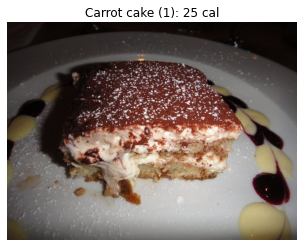

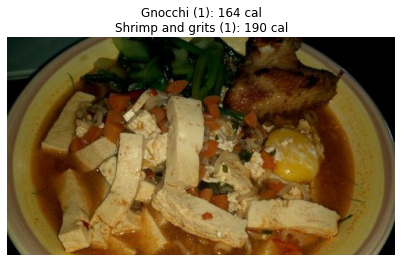

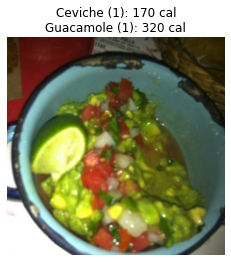

In [57]:
for (filepath, prediction_list) in predictions:

    # display image and calories
    plt.figure(figsize=(8,4))
    plt.axis('off')
    plt.imshow(pil_image.open(filepath))
    plt.title("\n".join([ f"{label.capitalize().replace('_',' ')} (1): {food_to_calorie_dict[label]} cal" for label in prediction_list ]))
    plt.show()

# Conclusion

This model is far from perfect, it is more of a proof of concept, but it shows how much can be achieved using deep learning techniques and some ingenuity. We learned a lot from the whole process of writing this model:

- how to use and combine multiple datasets
- how to efficiently use and even retrain a pretrained network
- how to employ different machine learning techniques to overcome limitations
- how to implement custom solutions to our training problems which don't come with TensorFlow
- how to control the training process at runtime using callbacks
- how to work as a team